In [ ]:
import os
# Check if the 'data' folder exists, create it if it doesn't
if not os.path.exists("data"):
    os.makedirs("data")

# 1. Download the wildfire data if needed
!curl "https://drive.usercontent.google.com/download?id={1plQkOC8zbhnqHoupdxVioOoaM8FYnEHt}&confirm=xxx" -o "./data/Ferguson_fire_background.npy"
!curl "https://drive.usercontent.google.com/download?id={1_u9KqsWjH45uozaWD6Ym3ZGYon88k6YI}&confirm=xxx" -o "./data/Ferguson_fire_obs.npy"
!curl "https://drive.usercontent.google.com/download?id={11eLWXq8ocg8snrHCLzlFf6hQg7j0V7Qy}&confirm=xxx" -o "./data/Ferguson_fire_train.zip"
!curl "https://drive.usercontent.google.com/download?id={1z8iDZ4X11v0PYb5QBLbnWiz7L-3gryqD}&confirm=xxx" -o "./data/Ferguson_fire_test.zip"

import zipfile
with zipfile.ZipFile("./data//Ferguson_fire_train.zip", 'r') as z:
    z.extractall('./data/')
with zipfile.ZipFile("./data//Ferguson_fire_test.zip", 'r') as z:
    z.extractall('./data/')
print('Data Download Done.')

# 2. Download trained model if needed
!curl "https://drive.usercontent.google.com/download?id={1fgOtmk4O5tUsXJ_LP_AF0b3pFOVj9W1J}&confirm=xxx" -o "./data/CAEGroup.pth.pth"

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from WildfireThomas.WildfireDA.models import CAE
from WildfireThomas.WildfireDA.task3functions import assimilate

In [2]:
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the data

In [3]:
background_dataset = np.load('data/Ferguson_fire_background.npy')
obs_dataset = np.load('data/Ferguson_fire_obs.npy')

print('background_dataset shape is: ', background_dataset.shape)
print('obs_dataset shape is: ', obs_dataset.shape)

background_dataset shape is:  (5, 256, 256)
obs_dataset shape is:  (5, 256, 256)


In [4]:
RNN_dataset = np.load('data/generated_images_RNN.npy')  # background data with the last image as the generated image from RNN
VAE_dataset = np.load('data/generated_images_VAE.npy')

RNN_result_dataset = RNN_dataset.reshape((5, 1, 256, 256))   # the original shape is (5,256,256)
VAE_result_dataset = VAE_dataset.reshape((5, 1, 256, 256))   # the original shape is (5,256,256)
print('RNN_pred_dataset shape is: ', RNN_result_dataset.shape)
print('VAE_pred_dataset shape is: ', VAE_result_dataset.shape)

RNN_pred_dataset shape is:  (5, 1, 256, 256)
VAE_pred_dataset shape is:  (5, 1, 256, 256)


### Load the model (trained in train_dataset)

In [5]:
model_CAE = CAE().to(device)
model_path = 'data/CAEGroup.pth'
model_CAE.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

### Prepare data
Convert dataset to 4-dimensional pytorch tensors as the input of trained models.

In [6]:
sensors_tensor = torch.tensor(obs_dataset, dtype=torch.float32).unsqueeze(1).to(device)
RNN_tensor = torch.tensor(RNN_result_dataset, dtype=torch.float32).to(device)
VAE_tensor = torch.tensor(VAE_result_dataset, dtype=torch.float32).to(device)

print('sensors_tensor shape is:', sensors_tensor.shape)
print('RNN_tensor shape is:', RNN_tensor.shape)
print('VAE_tensor shape is:', VAE_tensor.shape)

sensors_tensor shape is: torch.Size([5, 1, 256, 256])
RNN_tensor shape is: torch.Size([5, 1, 256, 256])
VAE_tensor shape is: torch.Size([5, 1, 256, 256])


In [7]:
obs_image = obs_dataset[-1]  # the last image from observation
generated_image_RNN = RNN_dataset[-1]  # the image generated by RNN

obs_image_tensor = torch.tensor(obs_dataset[-1], dtype=torch.float32).unsqueeze(0).unsqueeze(1).to(device)
generated_image_tensor = torch.tensor(generated_image_RNN, dtype=torch.float32).unsqueeze(0).unsqueeze(1).to(device)

print('observation_image_tensor shape is:', obs_image_tensor.shape)
print('generated_image_tensor shape is:', generated_image_tensor.shape)

observation_image_tensor shape is: torch.Size([1, 1, 256, 256])
generated_image_tensor shape is: torch.Size([1, 1, 256, 256])


### Encode: latent space (64, 64)

In [8]:
model_CAE.eval()
with torch.no_grad():
    encoded_sensor_data = model_CAE.encoder(sensors_tensor).cpu().numpy()
    encoded_model_data_RNN = model_CAE.encoder(RNN_tensor).cpu().numpy()
    encoded_model_data_VAE = model_CAE.encoder(VAE_tensor).cpu().numpy()

print("Shape of encoded data:", encoded_sensor_data.shape)
print("Shape of encoded RNN model data:", encoded_model_data_RNN.shape)
print("Shape of encoded VAE model data:", encoded_model_data_VAE.shape)

Shape of encoded data: (5, 1, 64, 64)
Shape of encoded RNN model data: (5, 1, 64, 64)
Shape of encoded VAE model data: (5, 1, 64, 64)


In [9]:
model_CAE.eval()
with torch.no_grad():
    encoded_obs_image = model_CAE.encoder(obs_image_tensor).cpu().numpy()
    encoded_generated_image = model_CAE.encoder(generated_image_tensor).cpu().numpy()

print("Shape of encoded data:", encoded_obs_image.shape)
print("Shape of encoded model data:", encoded_generated_image.shape)

Shape of encoded data: (1, 1, 64, 64)
Shape of encoded model data: (1, 1, 64, 64)


# RNN(ConvLSTM) Data Assimilation

### Assimilation on one generated image from RNN
For assimilation on one image, the latent space size is 64. Compute the covariance matrices from the compressed image.

In [10]:
latent_dim = encoded_obs_image.shape[2:][0]
print('Dimension of latent space is:', latent_dim)

Dimension of latent space is: 64


In [11]:
encoded_obs_image_flat = encoded_obs_image.reshape(-1, encoded_obs_image.shape[-1])
encoded_generated_image_flat = encoded_generated_image.reshape(-1, encoded_generated_image.shape[-1])

print('Flattened data shape is:', encoded_obs_image_flat.shape)

Flattened data shape is: (64, 64)


#### Compute the covariance matrices R and B and Kalman Gain

In [12]:
I = np.eye(latent_dim)
R = np.cov(encoded_obs_image_flat.T)*I*0.001
# R = I
B = np.cov(encoded_generated_image_flat.T)*I
H = I

In [13]:
# check if R and B have infinite condition number
assimilate.is_ill_conditioned(R)
assimilate.is_ill_conditioned(B)

Condition number: 2715.9204845963636
Condition number: 2697.1356488515435


In [14]:
K = assimilate.compute_kalman_gain(B, H, R)
print("Kalman Gain shape:", K.shape)

Kalman Gain shape: (64, 64)


In [15]:
# update model data with Kalman gain
updated_state_flattened = assimilate.update_state(encoded_generated_image_flat.T, K, H, encoded_obs_image_flat.T)

# reshape back to the original encoded shape
updated_state = updated_state_flattened.T.reshape(encoded_generated_image.shape)

#### Decode to original shape (5, 1, 256, 256)

In [16]:
updated_state_tensor = torch.tensor(updated_state, dtype=torch.float32).to(device)
with torch.no_grad():
    reconstructed_image_before = model_CAE.decoder(torch.tensor(encoded_generated_image, dtype=torch.float32).to(device)).cpu().numpy()
    reconstructed_image_after = model_CAE.decoder(updated_state_tensor).cpu().numpy()

print("Reconstructed images shape:", reconstructed_image_after.shape)

Reconstructed images shape: (1, 1, 256, 256)


#### Calculate MSE in the latent space

In [17]:
mse_latent_before = assimilate.mse(encoded_obs_image_flat, encoded_generated_image_flat)
mse_latent_after = assimilate.mse(encoded_obs_image_flat, updated_state_flattened.T)

print(f"MSE in latent space before assimilation: {mse_latent_before}")
print(f"MSE in latent space after assimilation: {mse_latent_after}")

MSE in latent space before assimilation: 2.7940561771392822
MSE in latent space after assimilation: 0.01301810225505759


#### Calculate MSE in the physical space

In [18]:
obs_reconstructed = obs_image_tensor.cpu().numpy()

mse_physical_before = assimilate.mse(obs_reconstructed, reconstructed_image_before)
mse_physical_after = assimilate.mse(obs_reconstructed, reconstructed_image_after)

print(f"MSE in physical space before assimilation: {mse_physical_before}")
print(f"MSE in physical space after assimilation: {mse_physical_after}")

MSE in physical space before assimilation: 0.09604015201330185
MSE in physical space after assimilation: 0.0040618497878313065


#### Plot the result

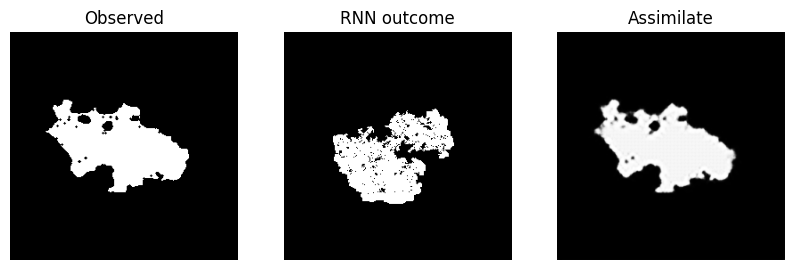

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].imshow(obs_image_tensor[0, 0], cmap='gray')
axes[0].set_title("Observed")
axes[0].axis('off')

axes[1].imshow(generated_image_tensor[0, 0], cmap='gray')
axes[1].set_title("RNN outcome")
axes[1].axis('off')

axes[2].imshow(reconstructed_image_after[0, 0], cmap='gray')
axes[2].set_title("Assimilate")
axes[2].axis('off')

plt.show()

### Assimilation on five background images, where the last one is generated by RNN
It may help to improve the assimilation result by computing the covariances from all five images due to more comprehensive feature extraction and noise reduction. For five images, the latent space dimension is the flattened size of each image. Then the covariance matrices is computed from all the flattened images.

#### Compute the covariance matrices R and B and Kalman Gain

In [20]:
num_images = encoded_sensor_data.shape[0]
latent_dim = np.prod(encoded_sensor_data.shape[2:])
print('Dimension of latent space is:', latent_dim)

encoded_sensor_data_flattened = encoded_sensor_data.reshape(num_images, latent_dim)
encoded_model_data_RNN_flattened = encoded_model_data_RNN.reshape(num_images, latent_dim)
print('Flattened data shape is:', encoded_sensor_data_flattened.shape)

Dimension of latent space is: 4096
Flattened data shape is: (5, 4096)


In [21]:
R = assimilate.compute_covariance_matrix(encoded_sensor_data_flattened)
B = assimilate.compute_covariance_matrix(encoded_model_data_RNN_flattened)
H = np.eye(latent_dim)

In [22]:
# check if matrix R and B are singular
assimilate.is_ill_conditioned(R)
assimilate.is_ill_conditioned(B)

Condition number: inf
Condition number: inf


In [23]:
# regularize R and B
R_regularized = assimilate.regularize_covariance(R)
B_regularized = assimilate.regularize_covariance(B, 100)

assimilate.is_ill_conditioned(R_regularized)
assimilate.is_ill_conditioned(B_regularized)

Condition number: 16.625505172156608
Condition number: 17.60904417006764


In [24]:
K = assimilate.compute_kalman_gain(B_regularized, H, R_regularized*0.001)
print("Kalman Gain shape:", K.shape)

Kalman Gain shape: (4096, 4096)


In [25]:
# update model data with Kalman gain
updated_state_flattened = assimilate.update_state(encoded_model_data_RNN_flattened.T, K, H, encoded_sensor_data_flattened.T)

# reshape back to the original encoded shape
updated_state = updated_state_flattened.T.reshape(encoded_model_data_RNN.shape)

#### Decode to original shape (5, 1, 256, 256)

In [26]:
updated_state_tensor = torch.tensor(updated_state, dtype=torch.float32).to(device)
with torch.no_grad():
    reconstructed_images_before = model_CAE.decoder(torch.tensor(encoded_model_data_RNN, dtype=torch.float32).to(device)).cpu().numpy()
    reconstructed_images_after = model_CAE.decoder(updated_state_tensor).cpu().numpy()

print("Reconstructed images shape:", reconstructed_images_after.shape)

Reconstructed images shape: (5, 1, 256, 256)


#### Calculate MSE in the latent space

In [27]:
# compute the mse between the generated image and its corresponding observation image
mse_latent_before = assimilate.mse(encoded_sensor_data_flattened[-1], encoded_model_data_RNN_flattened[-1])
mse_latent_after = assimilate.mse(encoded_sensor_data_flattened[-1], updated_state_flattened.T[-1])

print(f"MSE in latent space before assimilation: {mse_latent_before}")
print(f"MSE in latent space after assimilation: {mse_latent_after}")

MSE in latent space before assimilation: 2.7940561771392822
MSE in latent space after assimilation: 0.00024742291368197694


#### Calculate MSE in the physical space

In [28]:
sensors_reconstructed = sensors_tensor.cpu().numpy()

# compute the mse between the generated image and its corresponding observation image
mse_physical_before = assimilate.mse(sensors_reconstructed[-1], reconstructed_images_before[-1])
mse_physical_after = assimilate.mse(sensors_reconstructed[-1], reconstructed_images_after[-1])

print(f"MSE in physical space before assimilation: {mse_physical_before}")
print(f"MSE in physical space after assimilation: {mse_physical_after}")

MSE in physical space before assimilation: 0.09604015201330185
MSE in physical space after assimilation: 0.003638133406639099


#### Plot the result

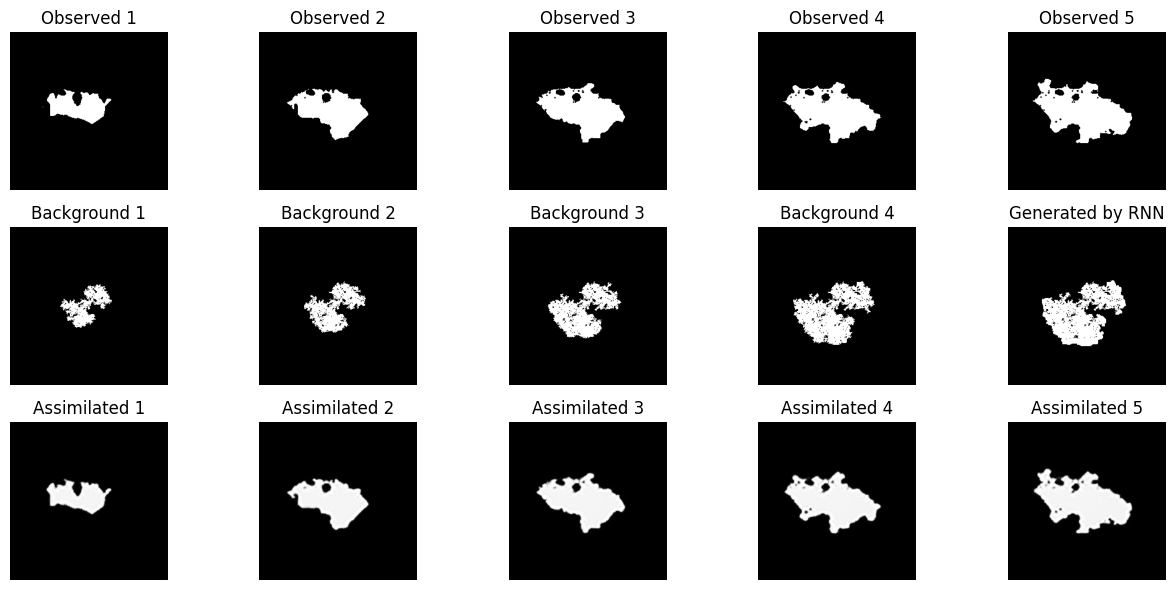

In [29]:
fig, axes = plt.subplots(3, 5, figsize=(13, 6))

for i in range(5):
    # Plot observed images
    axes[0, i].imshow(sensors_tensor[i, 0], cmap='gray')
    axes[0, i].set_title(f'Observed {i+1}')
    axes[0, i].axis('off')

    # Plot generated images
    axes[1, i].imshow(RNN_tensor[i, 0], cmap='gray')
    if i==4:
       axes[1, i].set_title(f'Generated by RNN')
    else:
       axes[1, i].set_title(f'Background {i+1}')
    axes[1, i].axis('off')

    # Plot assimilated images
    axes[2, i].imshow(reconstructed_images_after[i, 0], cmap='gray')
    axes[2, i].set_title(f'Assimilated {i+1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

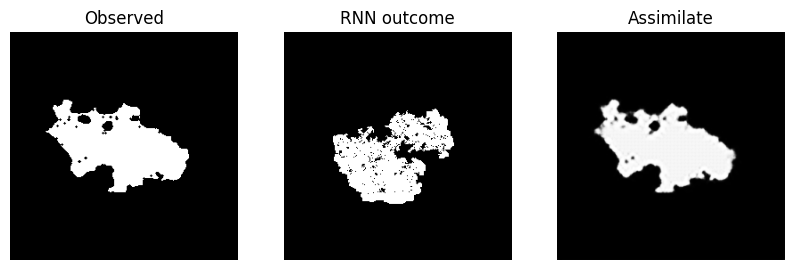

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].imshow(obs_image_tensor[0, 0], cmap='gray')
axes[0].set_title("Observed")
axes[0].axis('off')

axes[1].imshow(generated_image_tensor[0, 0], cmap='gray')
axes[1].set_title("RNN outcome")
axes[1].axis('off')

axes[2].imshow(reconstructed_image_after[0, 0], cmap='gray')
axes[2].set_title("Assimilate")
axes[2].axis('off')

plt.show()

# VAE Data Assimilation

### Compute the covariance matrices R and B and Kalman Gain

In [31]:
num_images = encoded_sensor_data.shape[0]
latent_dim = np.prod(encoded_sensor_data.shape[2:])
print('Dimension of latent space is:', latent_dim)

encoded_sensor_data_flattened = encoded_sensor_data.reshape(num_images, latent_dim)
encoded_model_data_VAE_flattened = encoded_model_data_VAE.reshape(num_images, latent_dim)
print('Flattened data shape is:', encoded_sensor_data_flattened.shape)

Dimension of latent space is: 4096
Flattened data shape is: (5, 4096)


In [32]:
R = assimilate.compute_covariance_matrix(encoded_sensor_data_flattened)
B = assimilate.compute_covariance_matrix(encoded_model_data_VAE_flattened)
H = np.eye(latent_dim)

In [33]:
assimilate.is_ill_conditioned(R)
assimilate.is_ill_conditioned(B)

Condition number: inf
Condition number: 4.5642594394138806e+26


In [34]:
# regularize R
R_regularized = assimilate.regularize_covariance(R)
assimilate.is_ill_conditioned(R_regularized)

Condition number: 16.625505172156608


In [35]:
K = assimilate.compute_kalman_gain(B_regularized, H, R_regularized*0.001)
print("Kalman Gain shape:", K.shape)

Kalman Gain shape: (4096, 4096)


In [36]:
updated_state_flattened = assimilate.update_state(encoded_model_data_VAE_flattened.T, K, H, encoded_sensor_data_flattened.T)
updated_state = updated_state_flattened.T.reshape(encoded_model_data_VAE.shape)

### Decode to original shape (5, 1, 256, 256)

In [37]:
updated_state_tensor = torch.tensor(updated_state, dtype=torch.float32).to(device)
with torch.no_grad():
    reconstructed_images_before = model_CAE.decoder(torch.tensor(encoded_model_data_VAE, dtype=torch.float32).to(device)).cpu().numpy()
    reconstructed_images_after = model_CAE.decoder(updated_state_tensor).cpu().numpy()

print("Reconstructed images shape:", reconstructed_images_after.shape)

Reconstructed images shape: (5, 1, 256, 256)


### Calculate MSE in the latent space

In [38]:
mse_latent_before = assimilate.mse(encoded_sensor_data_flattened, encoded_model_data_VAE_flattened)
mse_latent_after = assimilate.mse(encoded_sensor_data_flattened, updated_state_flattened.T)

print(f"MSE in latent space before assimilation: {mse_latent_before}")
print(f"MSE in latent space after assimilation: {mse_latent_after}")

MSE in latent space before assimilation: 2.075762987136841
MSE in latent space after assimilation: 0.00013305222408418406


### Calculate MSE in the physical space

In [39]:
sensors_reconstructed = sensors_tensor.cpu().numpy()

mse_physical_before = assimilate.mse(sensors_reconstructed, reconstructed_images_before)
mse_physical_after = assimilate.mse(sensors_reconstructed, reconstructed_images_after)

print(f"MSE in physical space before assimilation: {mse_physical_before}")
print(f"MSE in physical space after assimilation: {mse_physical_after}")

MSE in physical space before assimilation: 0.08894287049770355
MSE in physical space after assimilation: 0.0024576466530561447


### Plot the result

To facilitate a proper comparison of the images, let's apply a threshold to convert them to binary mode, distinguishing only between burnt and unburnt areas.

In [40]:
threshold = 0.1

binary_observed_image = (sensors_reconstructed > threshold).astype(int)
binary_generated_image = (VAE_dataset > threshold).astype(int)
binary_decoded_image = (reconstructed_images_after > threshold).astype(int)  # Reshape decoded_assimilation if needed


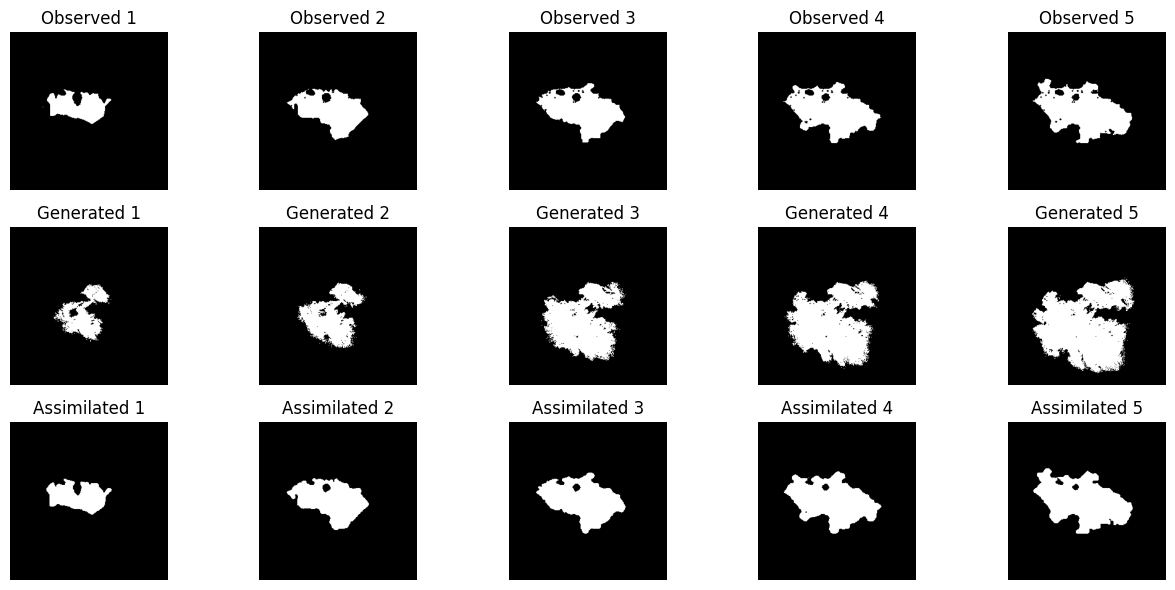

In [41]:
fig, axes = plt.subplots(3, 5, figsize=(13, 6))

for i in range(5):
    # Plot observed images
    axes[0, i].imshow(binary_observed_image[i, 0],cmap='gray')
    axes[0, i].set_title(f'Observed {i+1}')
    axes[0, i].axis('off')

    # Plot generated images
    axes[1, i].imshow(binary_generated_image[i, 0],cmap='gray')
    axes[1, i].set_title(f'Generated {i+1}')
    axes[1, i].axis('off')

    # Plot assimilated images
    axes[2, i].imshow(binary_decoded_image[i, 0],cmap='gray')
    axes[2, i].set_title(f'Assimilated {i+1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

The middle images depict those generated by the VAE model, showing a clear progression in the image sequence. This indicates that the model successfully captured the growth of the wildfire. The generated images feature blobs of unburnt areas, similar to those observed in the training data, likely representing lakes and water bodies that do not burn. However, the size of these blobs changes dynamically in the generated images, which does not match the observational data. After assimilation, these blobs stabilize, resulting in a more realistic depiction of a wildfire.

Regarding the numerical results, the Mean Squared Error (MSE) was significantly reduced in the physical space, from 0.089 before assimilation to 0.0025 after assimilation. This represents a reduction of approximately 97.24%. Thus, regularizing the matrices B and R proved to be an effective strategy for assimilation.